# Maximal Update Parametrization (muP) - coordinate checking

In [1]:
import math
from collections.abc import Callable, Iterator
from typing import Literal

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt

from cellarium.ml.models import MuLinear
from cellarium.ml.utilities.testing import get_coord_data

## Data processing

In [2]:
data_dir = "/tmp"
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


## Model definitions
A simple three layer MLP with SP and muP.

In [3]:
# SP MLP
class MLP(nn.Module):
    def __init__(self, width=128, num_classes=10, bias=False, nonlin=F.relu):
        super().__init__()
        self.nonlin = nonlin
        self.bias = bias
        self.fc_1 = nn.Linear(3072, width, bias=bias)
        self.fc_2 = nn.Linear(width, width, bias=bias)
        self.fc_3 = nn.Linear(width, num_classes, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        fan_in_1 = self.fc_1.weight.shape[1]
        # 1 / sqrt(d)
        nn.init.normal_(self.fc_1.weight, std=1 / math.sqrt(fan_in_1))
        fan_in_2 = self.fc_2.weight.shape[1]
        # 1 / sqrt(n)
        nn.init.normal_(self.fc_2.weight, std=1 / math.sqrt(fan_in_2))
        # zero readout
        nn.init.zeros_(self.fc_3.weight)
        if self.bias:
            # zero biases
            nn.init.zeros_(self.fc_1.bias)
            nn.init.zeros_(self.fc_2.bias)
            nn.init.zeros_(self.fc_3.bias)

    def forward(self, x):
        x = self.nonlin(self.fc_1(x))
        x = self.nonlin(self.fc_2(x))
        return self.fc_3(x)


# muP MLP
class MuMLP(nn.Module):
    def __init__(self, width=128, num_classes=10, bias=False, nonlin=F.relu, optimizer="sgd"):
        super().__init__()
        self.nonlin = nonlin
        self.fc_1 = MuLinear(3072, width, bias=bias, layer="input", optimizer=optimizer, init_scale=1 / math.sqrt(3072))
        self.fc_2 = MuLinear(width, width, bias=bias, layer="hidden", optimizer=optimizer)
        self.fc_3 = MuLinear(width, num_classes, bias=bias, layer="output", optimizer=optimizer)
        self.reset_parameters()

    def reset_parameters(self):
        # readout zero
        nn.init.zeros_(self.fc_3.weight_unscaled)

    def forward(self, x):
        x = self.nonlin(self.fc_1(x))
        x = self.nonlin(self.fc_2(x))
        return self.fc_3(x)

## Checking coordinate statistics

In [4]:
optim_dict = {"sgd": torch.optim.SGD, "adam": torch.optim.Adam, "adamw": torch.optim.AdamW}


# adapted from https://github.com/microsoft/mup/blob/main/examples/MLP/main.py
def coord_check_MLP(
    mup: bool,
    bias: bool,
    nonlin: Callable[[torch.Tensor], torch.Tensor],
    lr: float,
    optim_name: Literal["sgd", "adam", "adamw"],
    train_loader: torch.utils.data.DataLoader,
    nsteps: int,
    nseeds: int,
    widths: list[int],
) -> None:
    def gen(w: int) -> Callable[[], nn.Module]:
        def f() -> nn.Module:
            model: nn.Module
            if mup:
                model = MuMLP(width=w, bias=bias, nonlin=nonlin, optimizer=optim_name)
            else:
                model = MLP(width=w, bias=bias, nonlin=nonlin)
            return model

        return f

    models = {w: gen(w) for w in widths}
    optim_fn = optim_dict[optim_name]
    df = get_coord_data(
        models, train_loader, loss_fn=F.cross_entropy, lr=lr, optim_fn=optim_fn, nsteps=nsteps, nseeds=nseeds
    )

    # plot coordinates
    fig = plt.figure(figsize=(5 * nsteps, 10 + bias * 6))
    face_color = "xkcd:light grey" if not mup else None
    if face_color is not None:
        fig.patch.set_facecolor(face_color)
    n_rows = 3 + bias * 2
    for t in range(nsteps):
        df_t = df[df.t == t]
        # outputs
        plt.subplot(n_rows, nsteps, t + 1)
        sns.lineplot(x="width", y="l1", data=df_t[(df_t.type == "out")], hue="module", legend=True if t == 0 else None)
        plt.title(f"t={t}")
        if t != 0:
            plt.ylabel("")
        plt.loglog(base=2, nonpositive="mask")

        # parameter values
        plt.subplot(n_rows, nsteps, t + 1 + nsteps)
        sns.lineplot(
            x="width",
            y="l1",
            data=df_t[(df_t.type == "param") & (df_t.module.str.contains("weight"))],
            hue="module",
            legend=True if t == 0 else None,
        )
        if t != 0:
            plt.ylabel("")
        plt.loglog(base=2, nonpositive="mask")

        # parameter deltas
        plt.subplot(n_rows, nsteps, t + 1 + nsteps * 2)
        sns.lineplot(
            x="width",
            y="l1",
            data=df_t[(df_t.type == "delta") & (df_t.module.str.contains("weight"))],
            hue="module",
            legend=True if t == 0 else None,
        )
        if t != 0:
            plt.ylabel("")
        plt.loglog(base=2, nonpositive="mask")

        if bias:
            # bias values
            plt.subplot(n_rows, nsteps, t + 1 + nsteps * 3)
            sns.lineplot(
                x="width",
                y="l1",
                data=df_t[(df_t.type == "param") & (df_t.module.str.contains("bias"))],
                hue="module",
                legend=True if t == 0 else None,
            )
            if t != 0:
                plt.ylabel("")
            plt.loglog(base=2, nonpositive="mask")

            # bias deltas
            plt.subplot(n_rows, nsteps, t + 1 + nsteps * 4)
            sns.lineplot(
                x="width",
                y="l1",
                data=df_t[(df_t.type == "delta") & (df_t.module.str.contains("bias"))],
                hue="module",
                legend=True if t == 0 else None,
            )
            if t != 0:
                plt.ylabel("")
            plt.loglog(base=2, nonpositive="mask")
    prm = "μP" if mup else "SP"
    suptitle = f"{prm} MLP {optim_name} lr={lr} nseeds={nseeds}"
    plt.suptitle(suptitle)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [5]:
# scaling rules for coordinate sizes
# input wegiths & biases: W = 1; dW = 1
# output weights: W = 1/n; dW = 1/n
# hidden weights: W0 = 1/sqrt(n); dW = 1 / n

### SGD

/tmp/ipykernel_29436/678516845.py:86: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(base=2, nonpositive="mask")
/tmp/ipykernel_29436/678516845.py:103: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


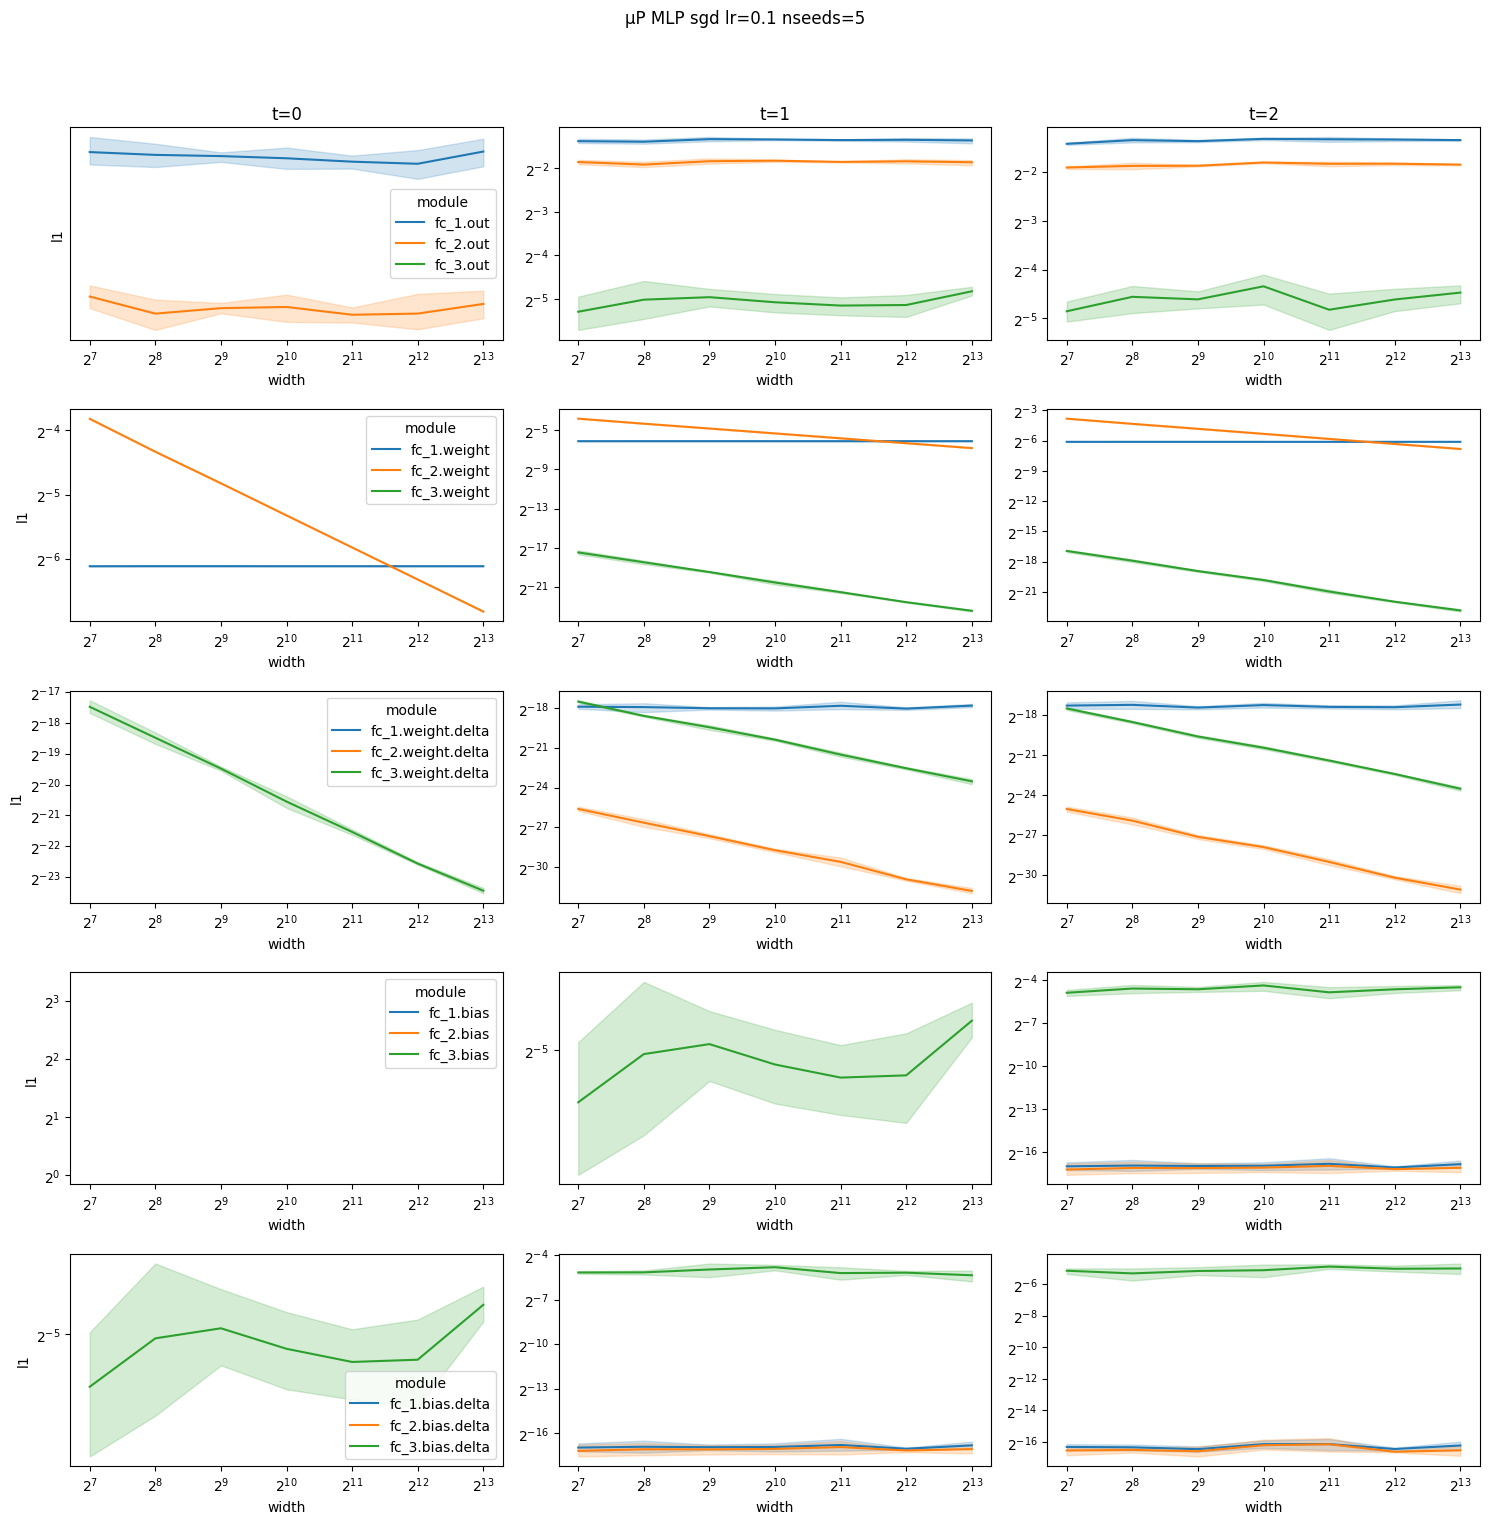

In [6]:
# muP SGD
coord_check_MLP(
    mup=True,
    bias=True,
    nonlin=F.relu,
    lr=0.1,
    optim_name="sgd",
    train_loader=train_loader,
    nsteps=3,
    nseeds=5,
    widths=[2**i for i in range(7, 14)],
)

/tmp/ipykernel_29436/678516845.py:86: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(base=2, nonpositive="mask")
/tmp/ipykernel_29436/678516845.py:103: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


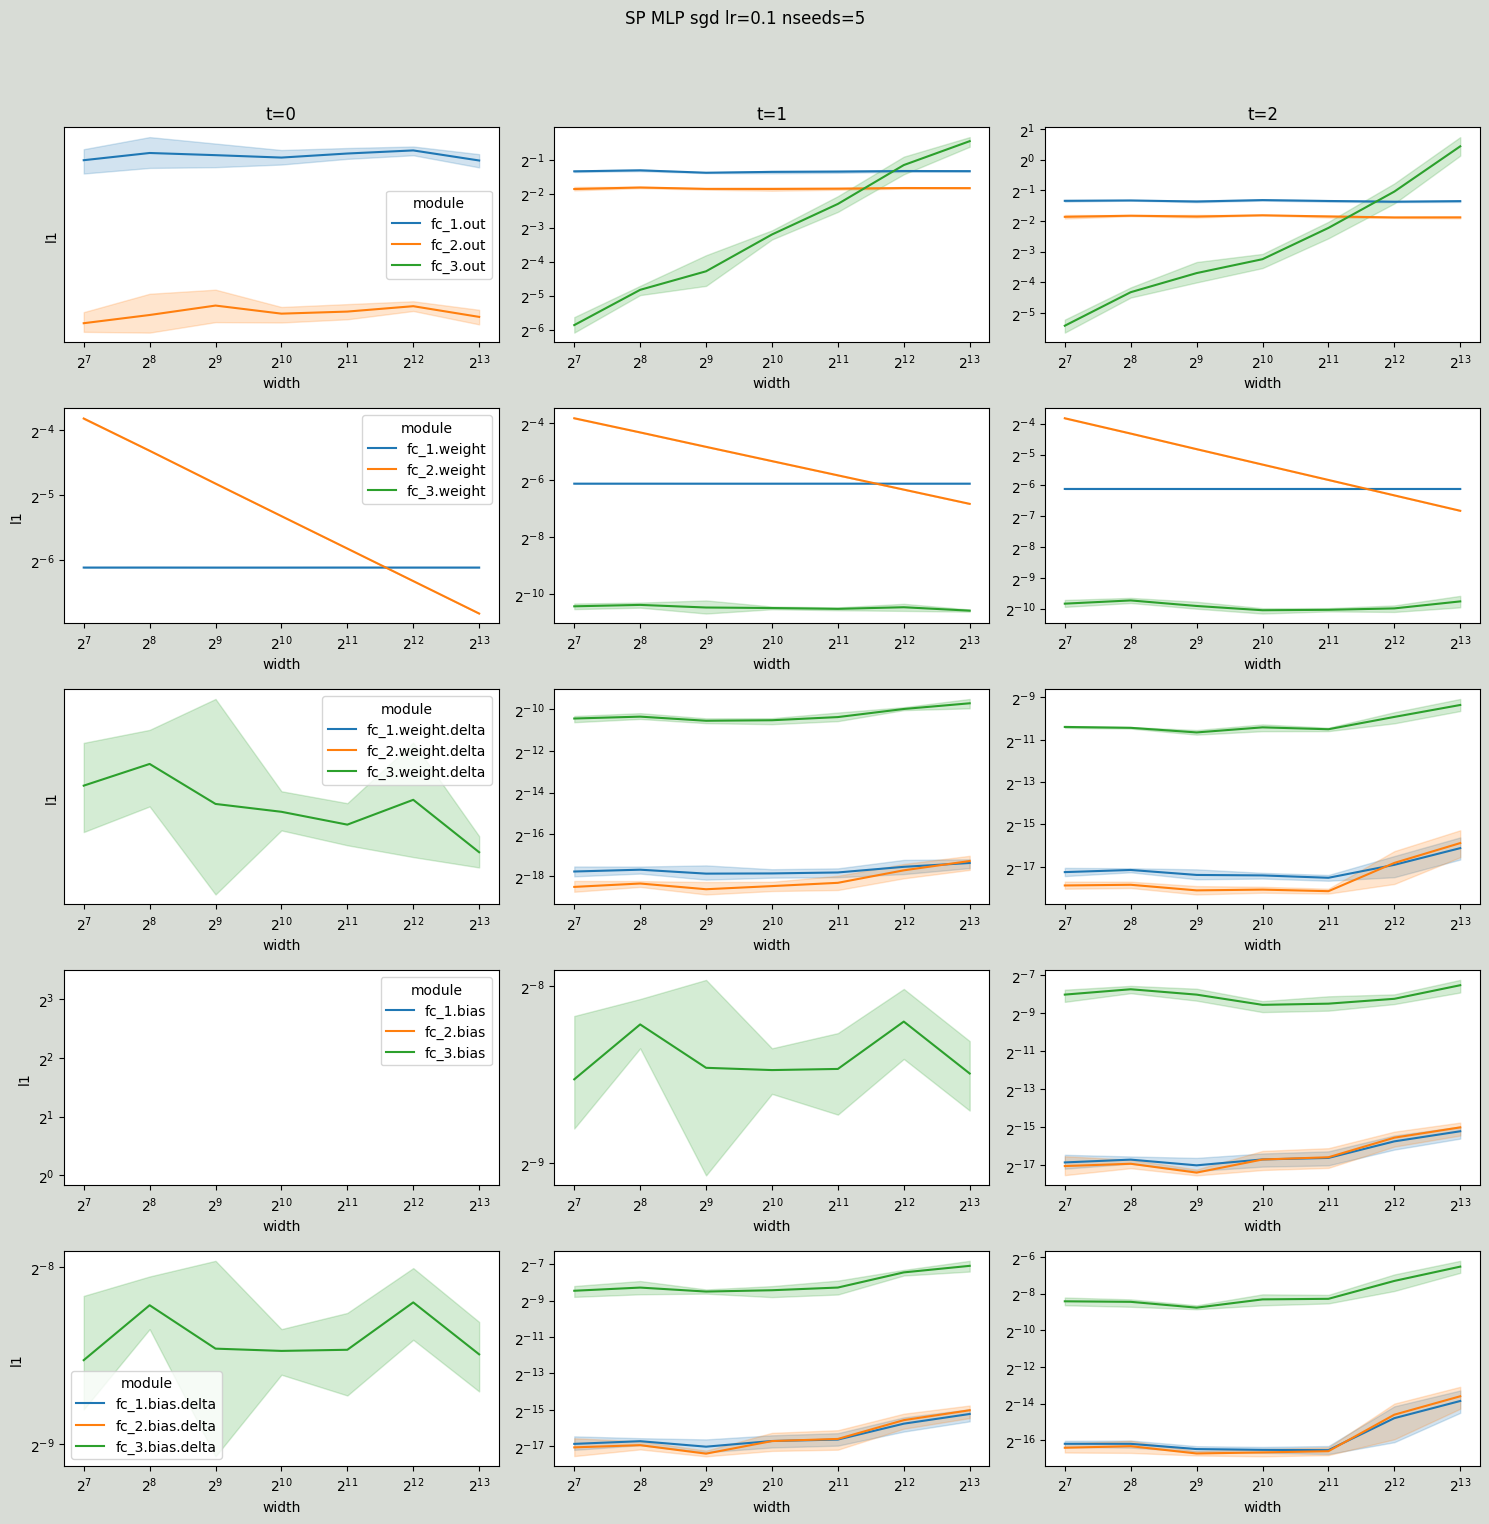

In [7]:
# SP SGD
coord_check_MLP(
    mup=False,
    bias=True,
    nonlin=F.relu,
    lr=0.1,
    optim_name="sgd",
    train_loader=train_loader,
    nsteps=3,
    nseeds=5,
    widths=[2**i for i in range(7, 14)],
)

### Adam

/tmp/ipykernel_29436/678516845.py:86: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(base=2, nonpositive="mask")
/tmp/ipykernel_29436/678516845.py:103: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


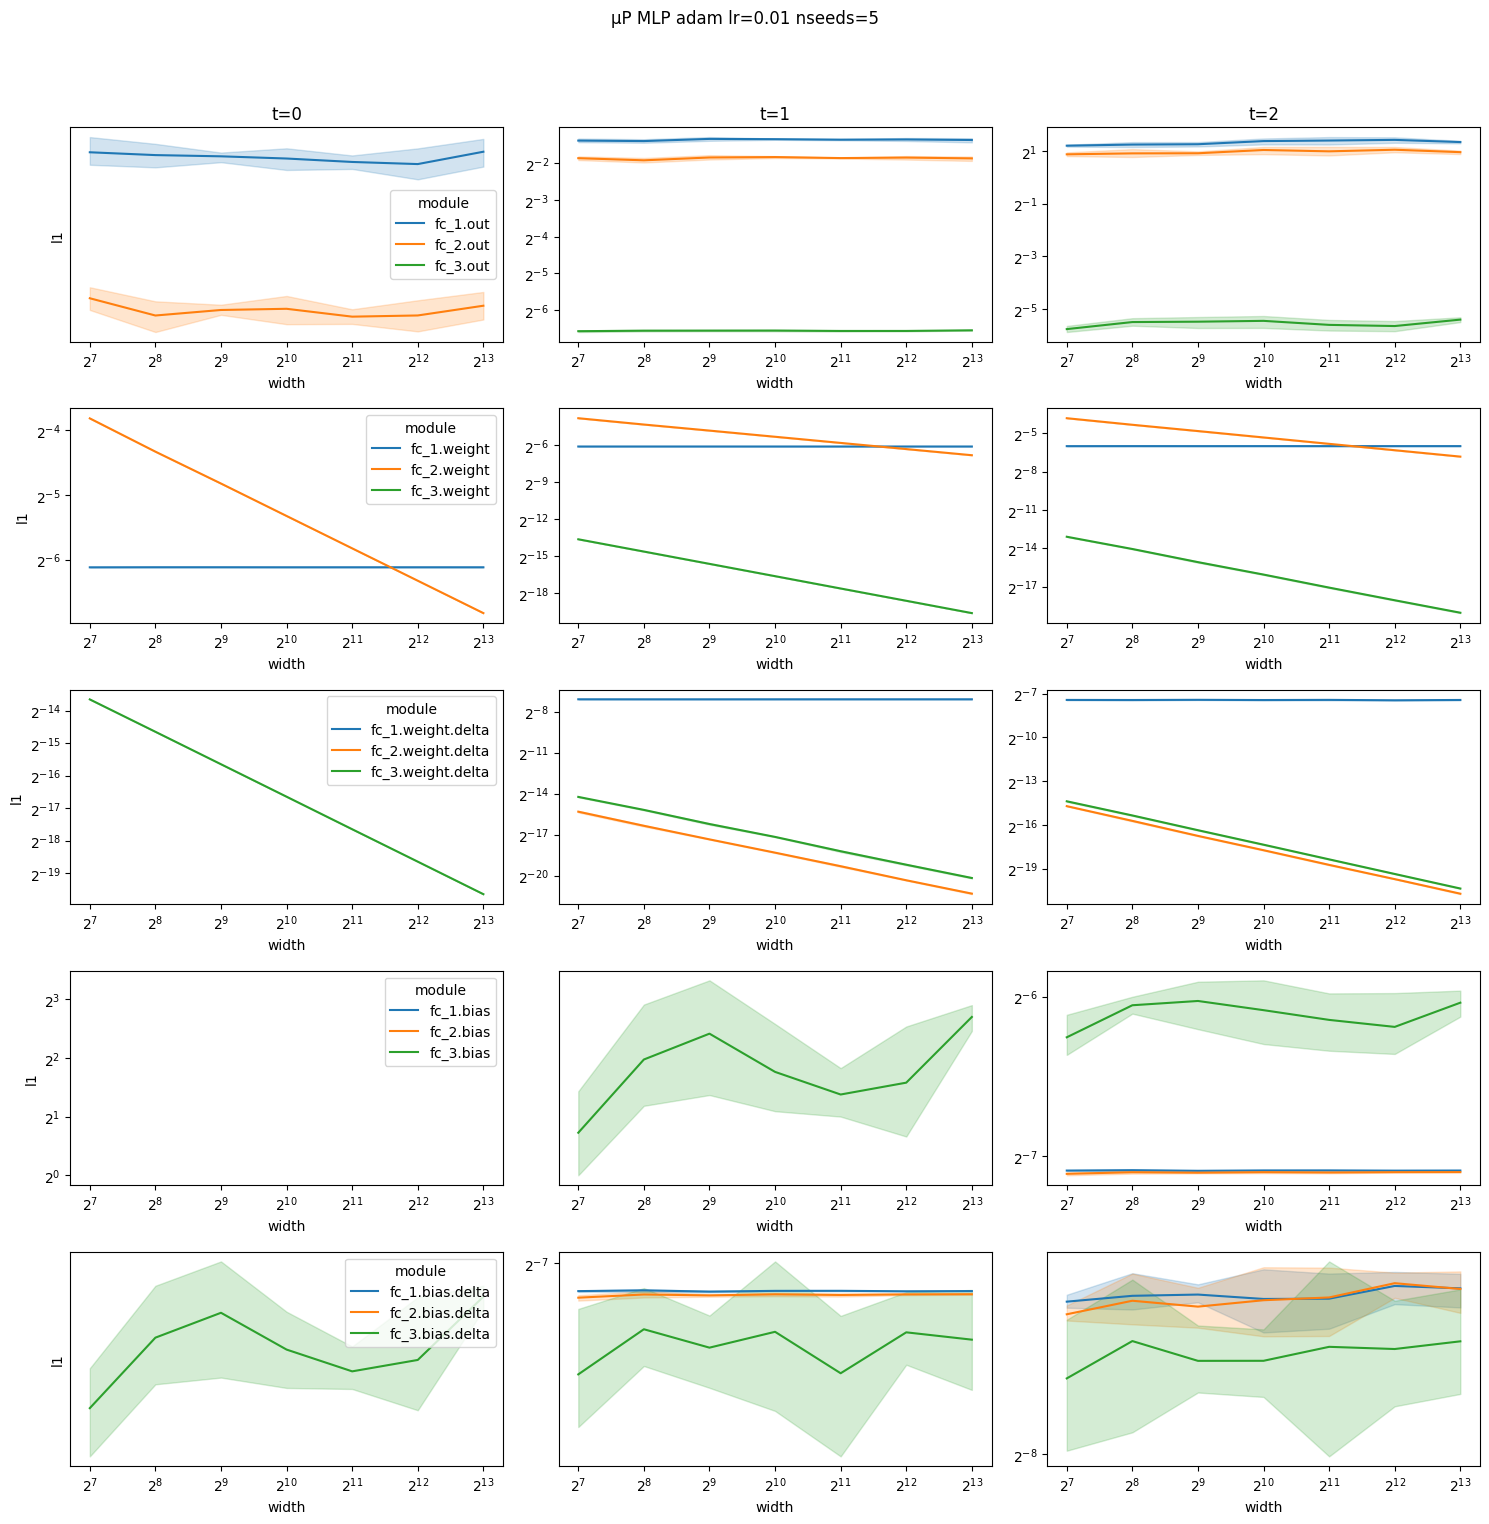

In [8]:
# muP Adam
coord_check_MLP(
    mup=True,
    bias=True,
    nonlin=F.relu,
    lr=0.01,
    optim_name="adam",
    train_loader=train_loader,
    nsteps=3,
    nseeds=5,
    widths=[2**i for i in range(7, 14)],
)

/tmp/ipykernel_29436/678516845.py:86: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(base=2, nonpositive="mask")
/tmp/ipykernel_29436/678516845.py:103: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


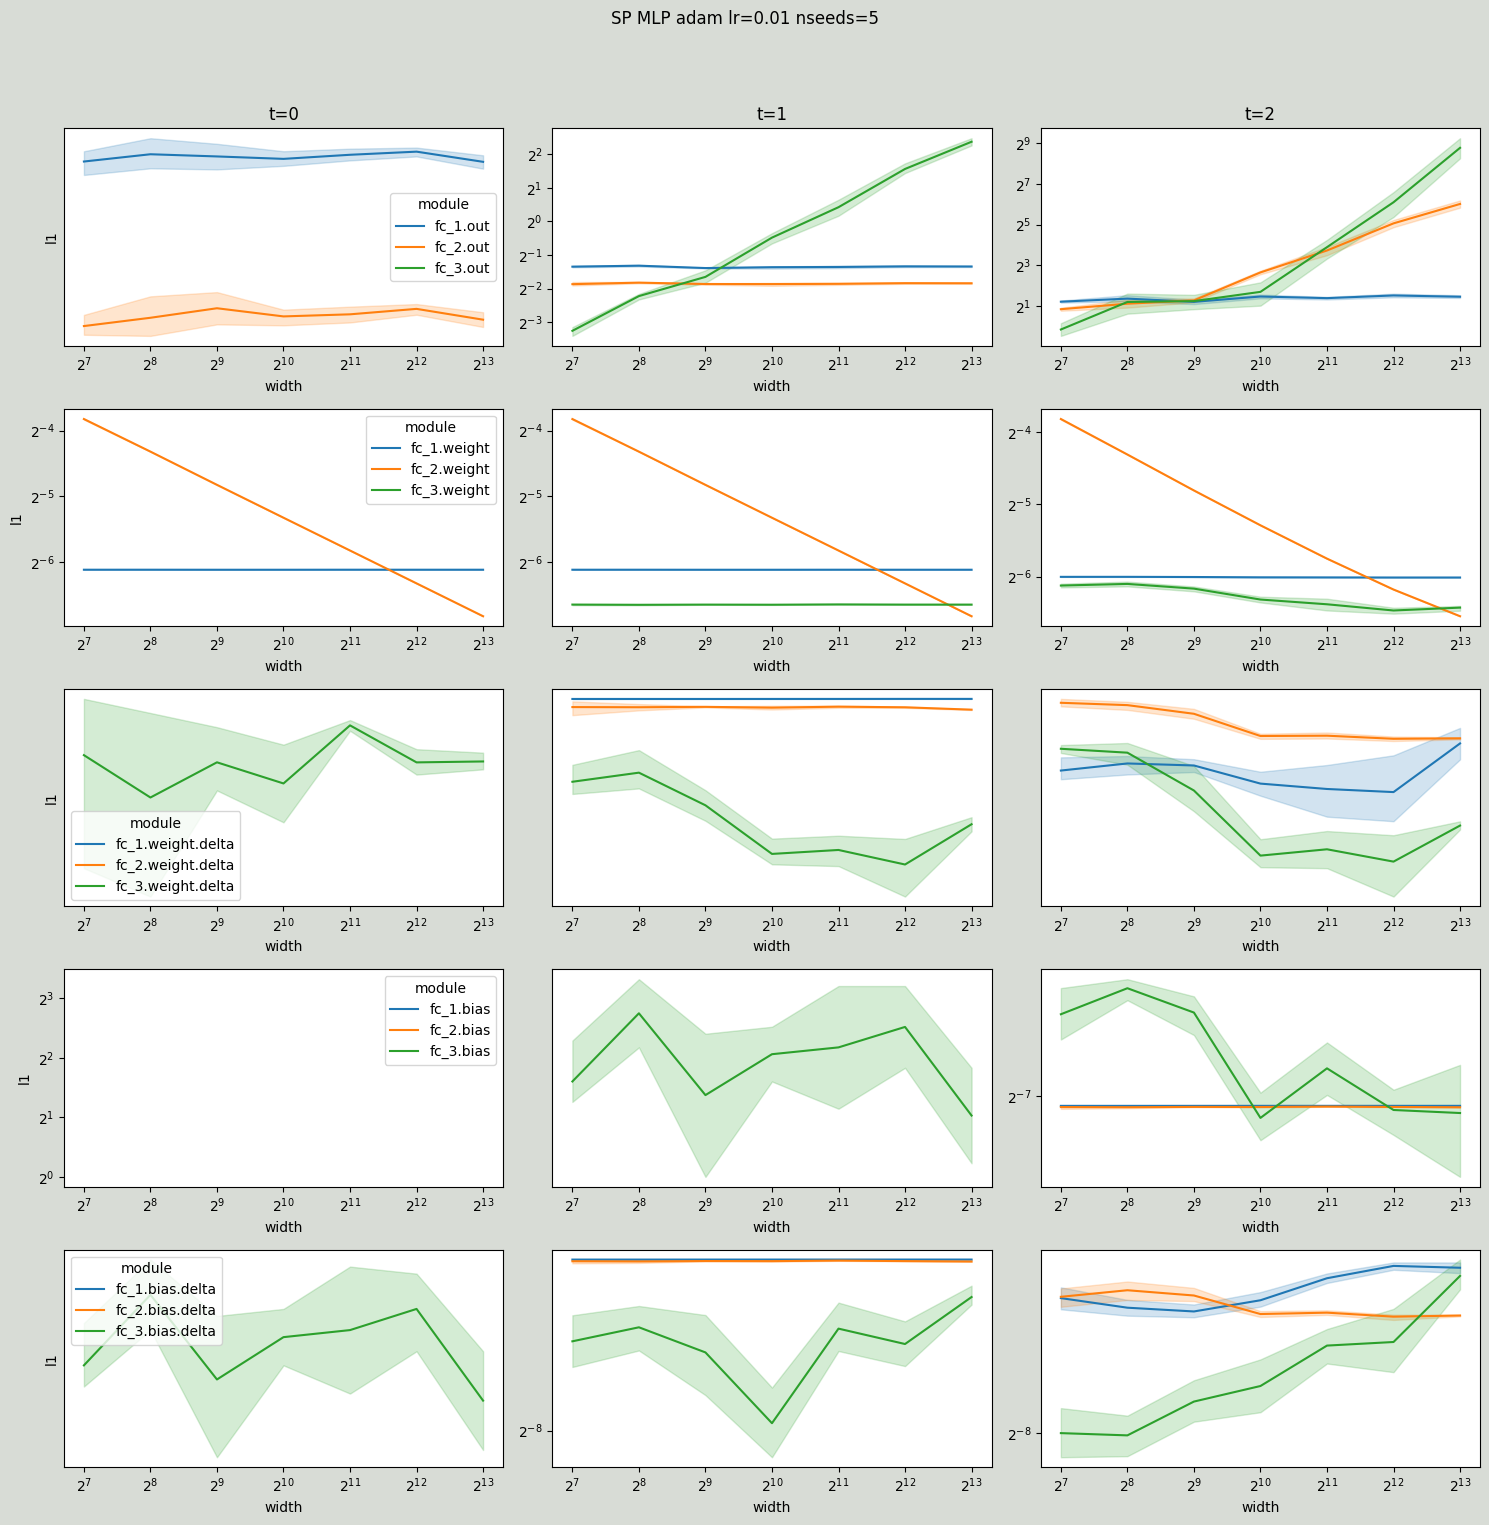

In [9]:
# SP Adam
coord_check_MLP(
    mup=False,
    bias=True,
    nonlin=F.relu,
    lr=0.01,
    optim_name="adam",
    train_loader=train_loader,
    nsteps=3,
    nseeds=5,
    widths=[2**i for i in range(7, 14)],
)

### AdamW

/tmp/ipykernel_29436/678516845.py:86: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(base=2, nonpositive="mask")
/tmp/ipykernel_29436/678516845.py:103: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


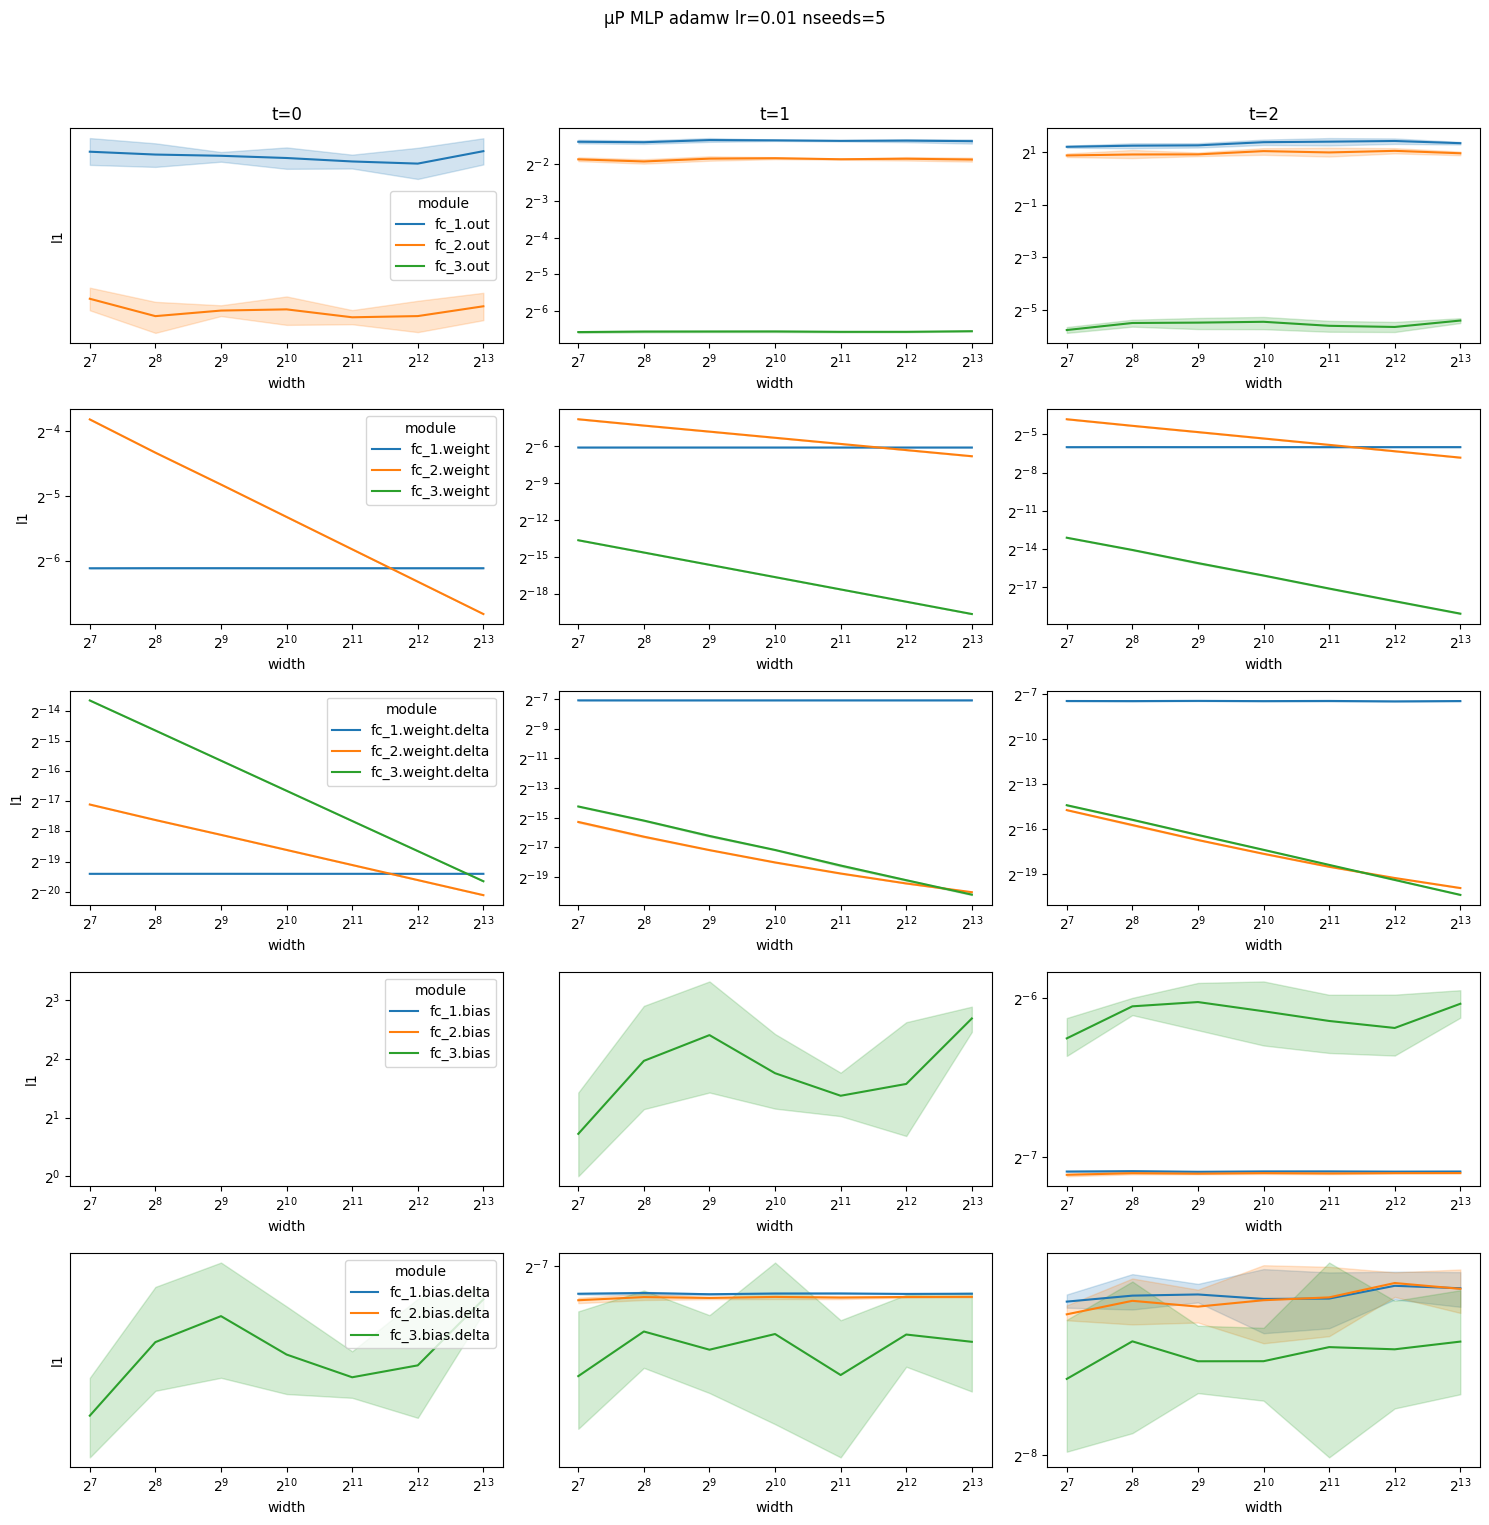

In [10]:
# muP AdamW
coord_check_MLP(
    mup=True,
    bias=True,
    nonlin=F.relu,
    lr=0.01,
    optim_name="adamw",
    train_loader=train_loader,
    nsteps=3,
    nseeds=5,
    widths=[2**i for i in range(7, 14)],
)

/tmp/ipykernel_29436/678516845.py:86: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(base=2, nonpositive="mask")
/tmp/ipykernel_29436/678516845.py:103: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


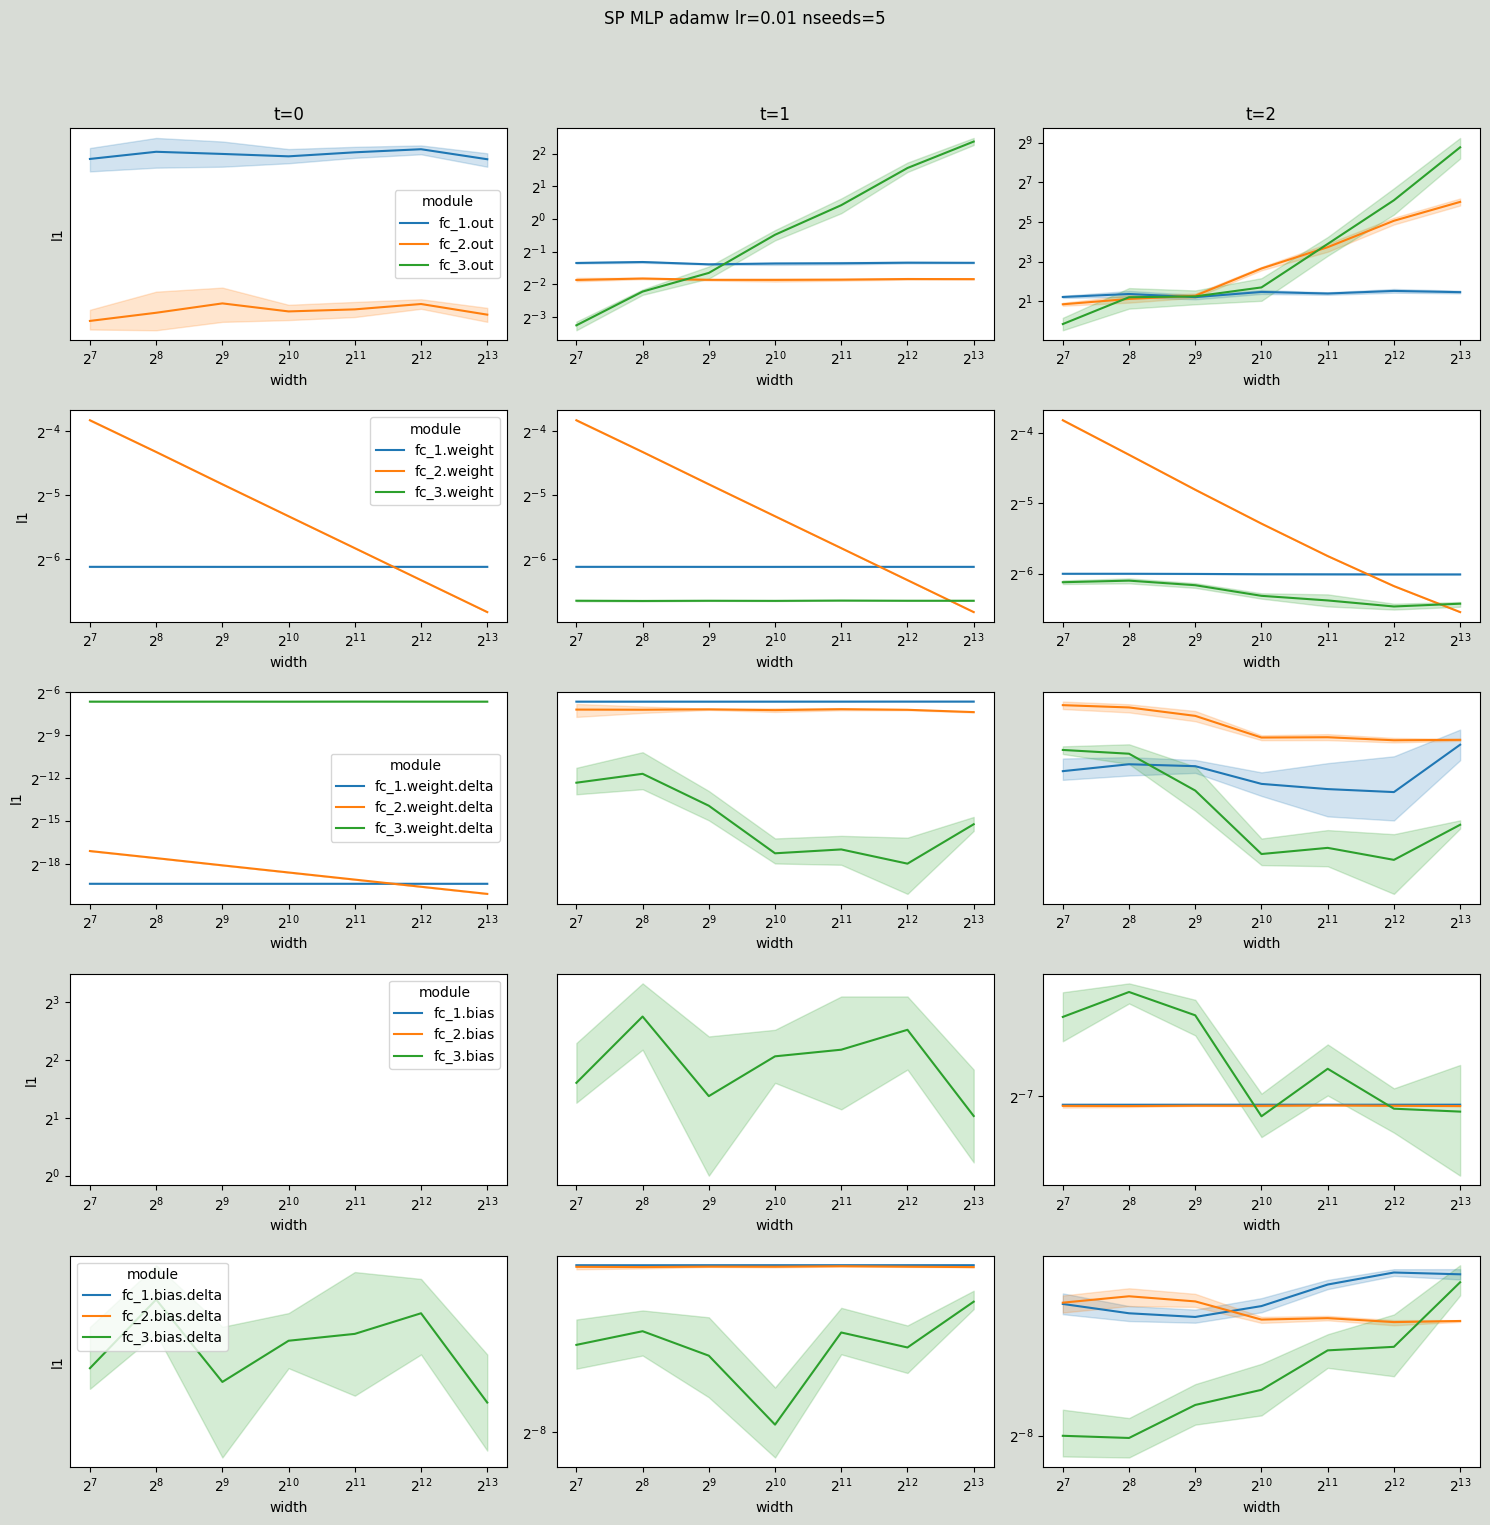

In [11]:
# SP AdamW
coord_check_MLP(
    mup=False,
    bias=True,
    nonlin=F.relu,
    lr=0.01,
    optim_name="adamw",
    train_loader=train_loader,
    nsteps=3,
    nseeds=5,
    widths=[2**i for i in range(7, 14)],
)